
<div>
<center>
    <br>
    <h1>UNIVERSITY OF LONDON INTERNATIONAL PROGRAMMES</h1>
    <h2>Bachelor of Science (Honours) in Computer Science</h2><br>
    <img src="assets/UOL-Insignia.png" width="200"/><br>
    <h1><b>Deep Learning Breast Cancer Detection</b></h1>
    <h3>Author: Wong Zheng Jie <br><br>
    10246254<br><br><br>
    University of London<br><br>
    Singapore Institute of Management<br><br>
    Module: CM3015 Machine Learning and Neural Networks<br><br>
    Supervisor: Mr Hai Kian Loh<br><br><br>
    Singapore 25 May 2025</h3>
    <br>
</center>
</div>


 ---

## Abstract

<span style="color:red">
    
Although this notebook is not the main report, it still consists of sections such as Aim and Objectives and Motivations to provide context for subsequent cells.

</span>

## Defining the problem and assembling a dataset

The primary objective outlined in this project is a supervised image classification problem, where an initial model is developed to differentiate between mammographic images with and without indications of breast cancer, and is progressively improved upon. Classification is carried out using diagnostic labels found in the dataset, particularly distinguishing between malignant and non-malignant instances.

For this project, the Mini-DDSM dataset [3][4] is utilized as the primary dataset. As outlined in Section 1.2 Data Source and Relevancy, it includes annotated mammogram images in standard formats and has been prepared for seamless integration into deep learning processes. The dataset should be split into training, validation, and testing subsets, guaranteeing a stratified class distribution to keep balance throughout each set.


## Choosing a measure of success

In a medical setting, especially for potential clinical settings, like breast cancer detection, depending exclusively on accuracy as a performance measure can be deceptive, particularly in datasets with class imbalance or when the cost of misclassification is asymmetric. In this project, a true positive prediction (detecting cancer when it exists) holds considerably more clinical significance than a true negative prediction. On the other hand, a false negative (wrongly indicating that cancer is absent) might result in postponed diagnosis and treatment, making it crucial to minimise such probable mistakes.

While accuracy will be reported, it is not the main success criterion. To achieve a more comprehensive insight into model behaviour, confusion matrix will be used to illustrate the tallies of true positives, true negatives, false positives, and false negatives. This allows for immediate understanding of the kinds of mistakes the model is making and their frequency. To guarantee a thorough assessment, the following set of applicable performance indicators will also be applied:

- Sensitivity (Recall)
Evaluates the ratio of correctly identified actual positive cases (malignant). Having high sensitivity is essential for reducing the number of false negatives.

- Specificity
Evaluates the model’s capacity to accurately recognize negative instances (benign or normal), aiding in the decrease of false positives.

- Precision
Shows the fraction of accurate positive predictions, taking false positives into account.


- F1-Score
The harmonic mean of precision and recall is beneficial for assessing performance when both false positives and false negatives are relevant.


- Area Under the ROC Curve (AUC-ROC)
Represents the balance between true positive and false positive rates at different thresholds and offers a solid metric of separability.

These metrics will be evaluated on the validation and testing datasets to determine both model performance and generalization. The model's effectiveness will not solely be determined by its numerical outcomes across these metrics but also by its consistency and dependability in reducing significant errors.


## Deciding on an evaluation protocol

To guarantee a strong and impartial assessment of model effectiveness, a clearly defined evaluation protocol should be created. The data is divided into three separate subsets: training, validation, and testing. This permits distinct stages of learning, model adjustment, and ultimate performance assessment without data contamination or overfitting to the test dataset.

The stratified splitting approach is planned to be utilized to preserve the identical ratio of malignant and non-malignant cases throughout all three subsets. This is crucial in medical imaging tasks, where imbalanced datasets frequently occur and might otherwise result in distorted or misleading performance metrics.

Due to the moderate scale of the Mini-DDSM dataset, approaches like data augmentation may be employed to enhance the effective training size and minimize overfitting. Moreover, early stopping and cross-validation could be considered to guarantee that the model generalizes effectively and is not overly tailored to the validation dataset.

This evaluation protocol guarantees that performance metrics accurately represent the model’s generalization capability, especially in real-world clinical screening and medical settings, by distinctly separating training, validation, and testing phases while employing stratified sampling.


## Preparing your data

### Importing Libraries

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import random
import seaborn as sns
import cv2
import glob
from keras.preprocessing import image

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, callbacks

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

### Loading and Preaparing Dataset

Before preparing the dataset for training, we should understand the data we are dealing with. The Mini-DDSM file structure was examined and included a JPEG-8 and PNG-16 version. The PNG-16 format was chosen because it means 16-bit depth, preserving significantly more pixel intensity details, which is crucial for identifying slight tissue variations. The images are organized into a folder for training purposes and csv file was created to locate masks for identifying cancer biomarker locations.

In [3]:
# directories
# Original Source Folder
source_dir = 'The Complete Mini-DDSM archive/MINI-DDSM-Complete-PNG-16'
# Folder to store images
combined_img_dir = 'Combined_MiniDDSM_imgs'
# Folder to store Mask images
combined_img_mask_dir = 'Combined_MiniDDSM_img_Masks'

# Create output directories for images and masks
for root in [combined_img_dir, combined_img_mask_dir]:
    os.makedirs(root, exist_ok=True)
    for label in ['Benign', 'Cancer', 'Normal']:
        os.makedirs(os.path.join(root, label), exist_ok=True)

# copy images and masks
for label in ['Benign', 'Cancer', 'Normal']:
    label_path = os.path.join(source_dir, label)
    target_label_path = os.path.join(combined_img_dir, label)
    target_mask_label_path = os.path.join(combined_img_mask_dir, label)

    for case_id in os.listdir(label_path):
        case_path = os.path.join(label_path, case_id)

        if os.path.isdir(case_path):
            for file in os.listdir(case_path):
                if file.endswith(('CC.png', 'MLO.png')) and 'Mask' not in file:
                    
                    # Copy image file to the new image folder
                    src_img = os.path.join(case_path, file)
                    dst_img = os.path.join(target_label_path, file)
                    shutil.copyfile(src_img, dst_img)
            
                    # Copy mask image file to the new mask image folder
                    mask_name = file.replace('.png', '_Mask.png')
                    src_mask = os.path.join(case_path, mask_name)
                    if os.path.exists(src_mask):
                        dst_mask = os.path.join(target_mask_label_path, mask_name)
                        shutil.copyfile(src_mask, dst_mask)
    
print(f"Copy Complete")

Copy Complete


In [4]:
# Empty list to hold metadata for images and mask images
data = []

# Iterates over each directory inside the combined image folder
for label in os.listdir(combined_img_dir):
    label_combined_img_dir = os.path.join(combined_img_dir, label)
    label_combined_img_mask_dir = os.path.join(combined_img_mask_dir, label)

    if os.path.isdir(label_combined_img_dir):
        for fname in os.listdir(label_combined_img_dir):
            if fname.lower().endswith('.png'):
                img_path = os.path.join(label_combined_img_dir, fname)
                mask_name = fname.replace('.png', '_Mask.png')
                mask_path = os.path.join(label_combined_img_mask_dir, mask_name)

                # If mask exists then add it to the metadata else label as None
                if os.path.exists(mask_path):
                    data.append({'image_path': img_path, 'mask_path': mask_path, 'label': label})
                else:
                    data.append({'image_path': img_path, 'mask_path': None, 'label': label})

# saving metadata csv file
df = pd.DataFrame(data)
df.to_csv("Combined_MiniDDSM_Metadata.csv", index=False)
print("Saved Combined_MiniDDSM_Metadata.csv")

Saved Combined_MiniDDSM_Metadata.csv


Benign: 2684 images
Cancer: 2716 images
Normal: 2408 images


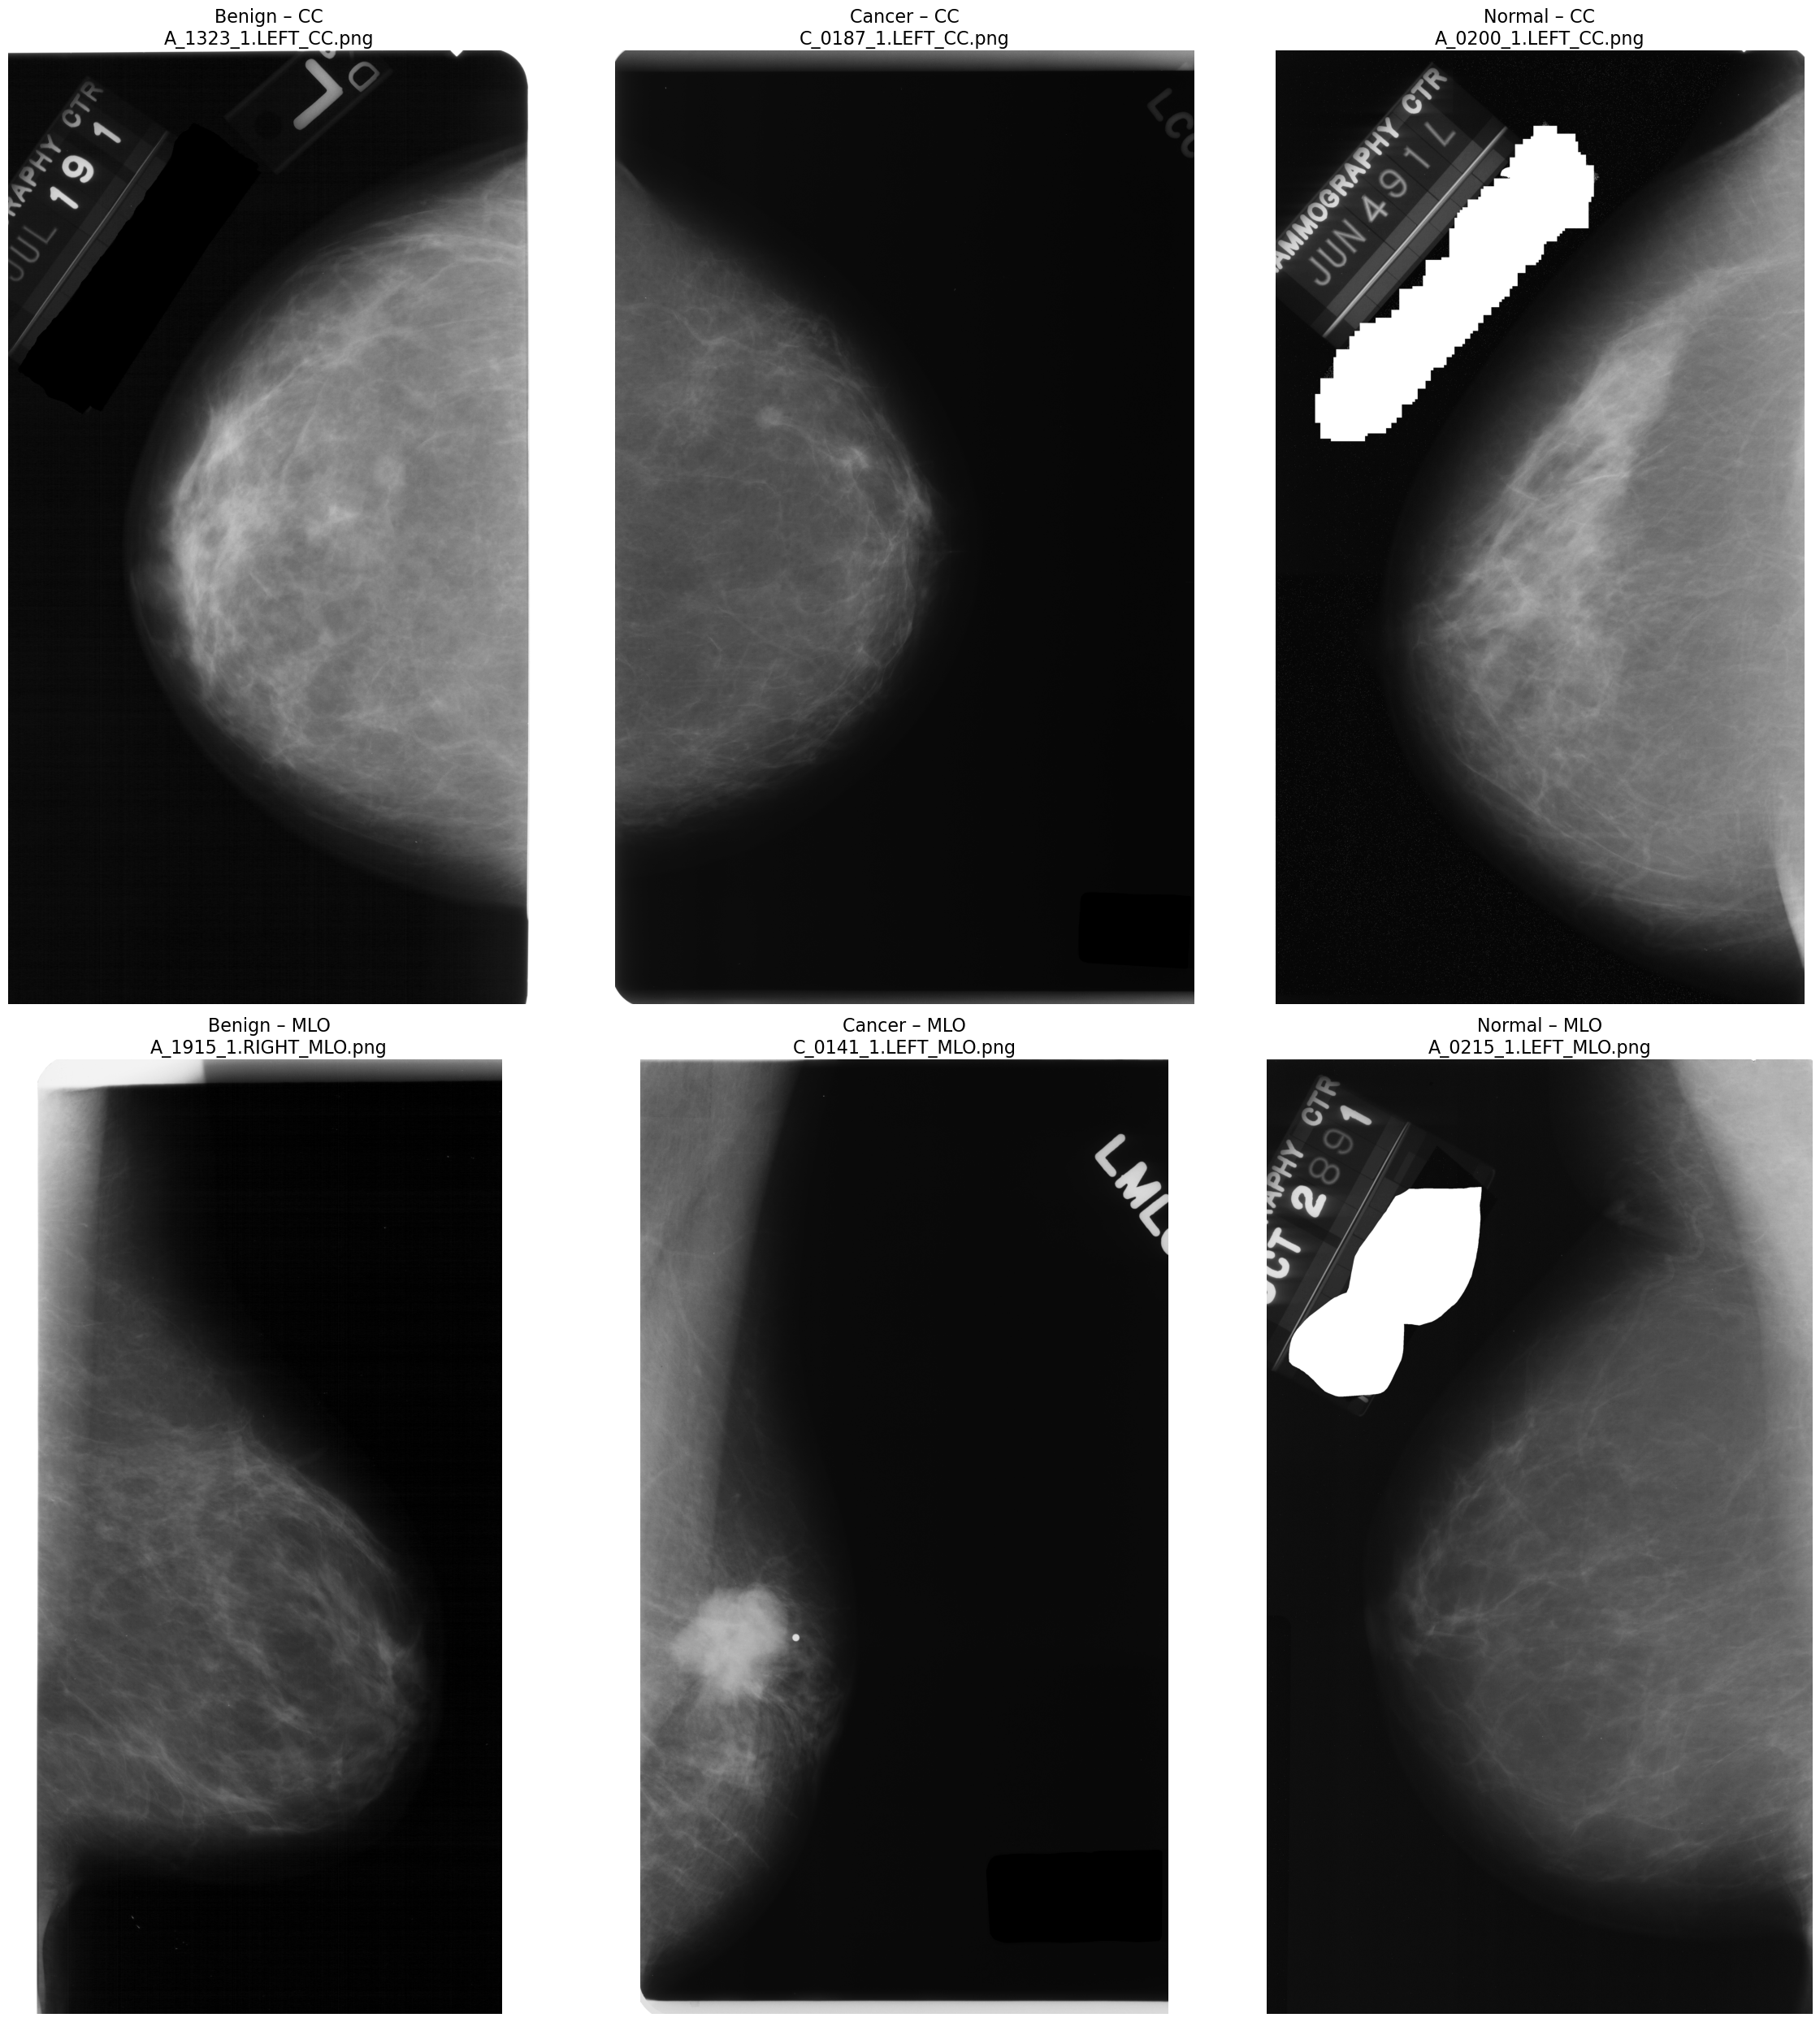

In [8]:
# Classification labels
classes = ['Benign', 'Cancer', 'Normal']

# Print number of .png images per class
for label in os.listdir(combined_img_dir):
    class_path = os.path.join(combined_img_dir, label)
    if os.path.isdir(class_path):
        image_list = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]
        print(f"{label}: {len(image_list)} images")

# Creating figure for viewing
# 1 rows for viewing 'Benign', 'Cancer', 'Normal' CC images and 1 row for viewing 'Benign', 'Cancer', 'Normal' MLO images.
fig, axs = plt.subplots(2, len(classes), figsize=(24, 25))

for col, label in enumerate(classes):
    class_path = os.path.join(combined_img_dir, label)
    all_images = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]

    # randomly picks one CC image
    cc_images = [f for f in all_images if '_CC.png' in f]
    if cc_images:
        cc_file = random.choice(cc_images)
        cc_path = os.path.join(class_path, cc_file)
        cc_img = cv2.imread(cc_path, cv2.IMREAD_GRAYSCALE)
        if cc_img is not None:
            axs[0, col].imshow(cc_img, cmap='gray')
            axs[0, col].set_title(f"{label} – CC\n{cc_file}", fontsize=16)
        else:
            axs[0, col].set_title(f"{label} – CC\n(Load failed)", fontsize=16)
    axs[0, col].axis('off')

    # randomly picks one MLO image
    mlo_images = [f for f in all_images if '_MLO.png' in f]
    if mlo_images:
        mlo_file = random.choice(mlo_images)
        mlo_path = os.path.join(class_path, mlo_file)
        mlo_img = cv2.imread(mlo_path, cv2.IMREAD_GRAYSCALE)
        if mlo_img is not None:
            axs[1, col].imshow(mlo_img, cmap='gray')
            axs[1, col].set_title(f"{label} – MLO\n{mlo_file}", fontsize=16)
        else:
            axs[1, col].set_title(f"{label} – MLO\n(Load failed)", fontsize=16)
    axs[1, col].axis('off')

plt.tight_layout()
plt.show()

The folders included 2 views for each breast, CC and MLO. The CC view presents a vertical (top down) perspective, displaying a larger portion of the whole breast, while the MLO view offers a lateral (side view) perspective of the breast, generally highlighting more of the upper outer area.

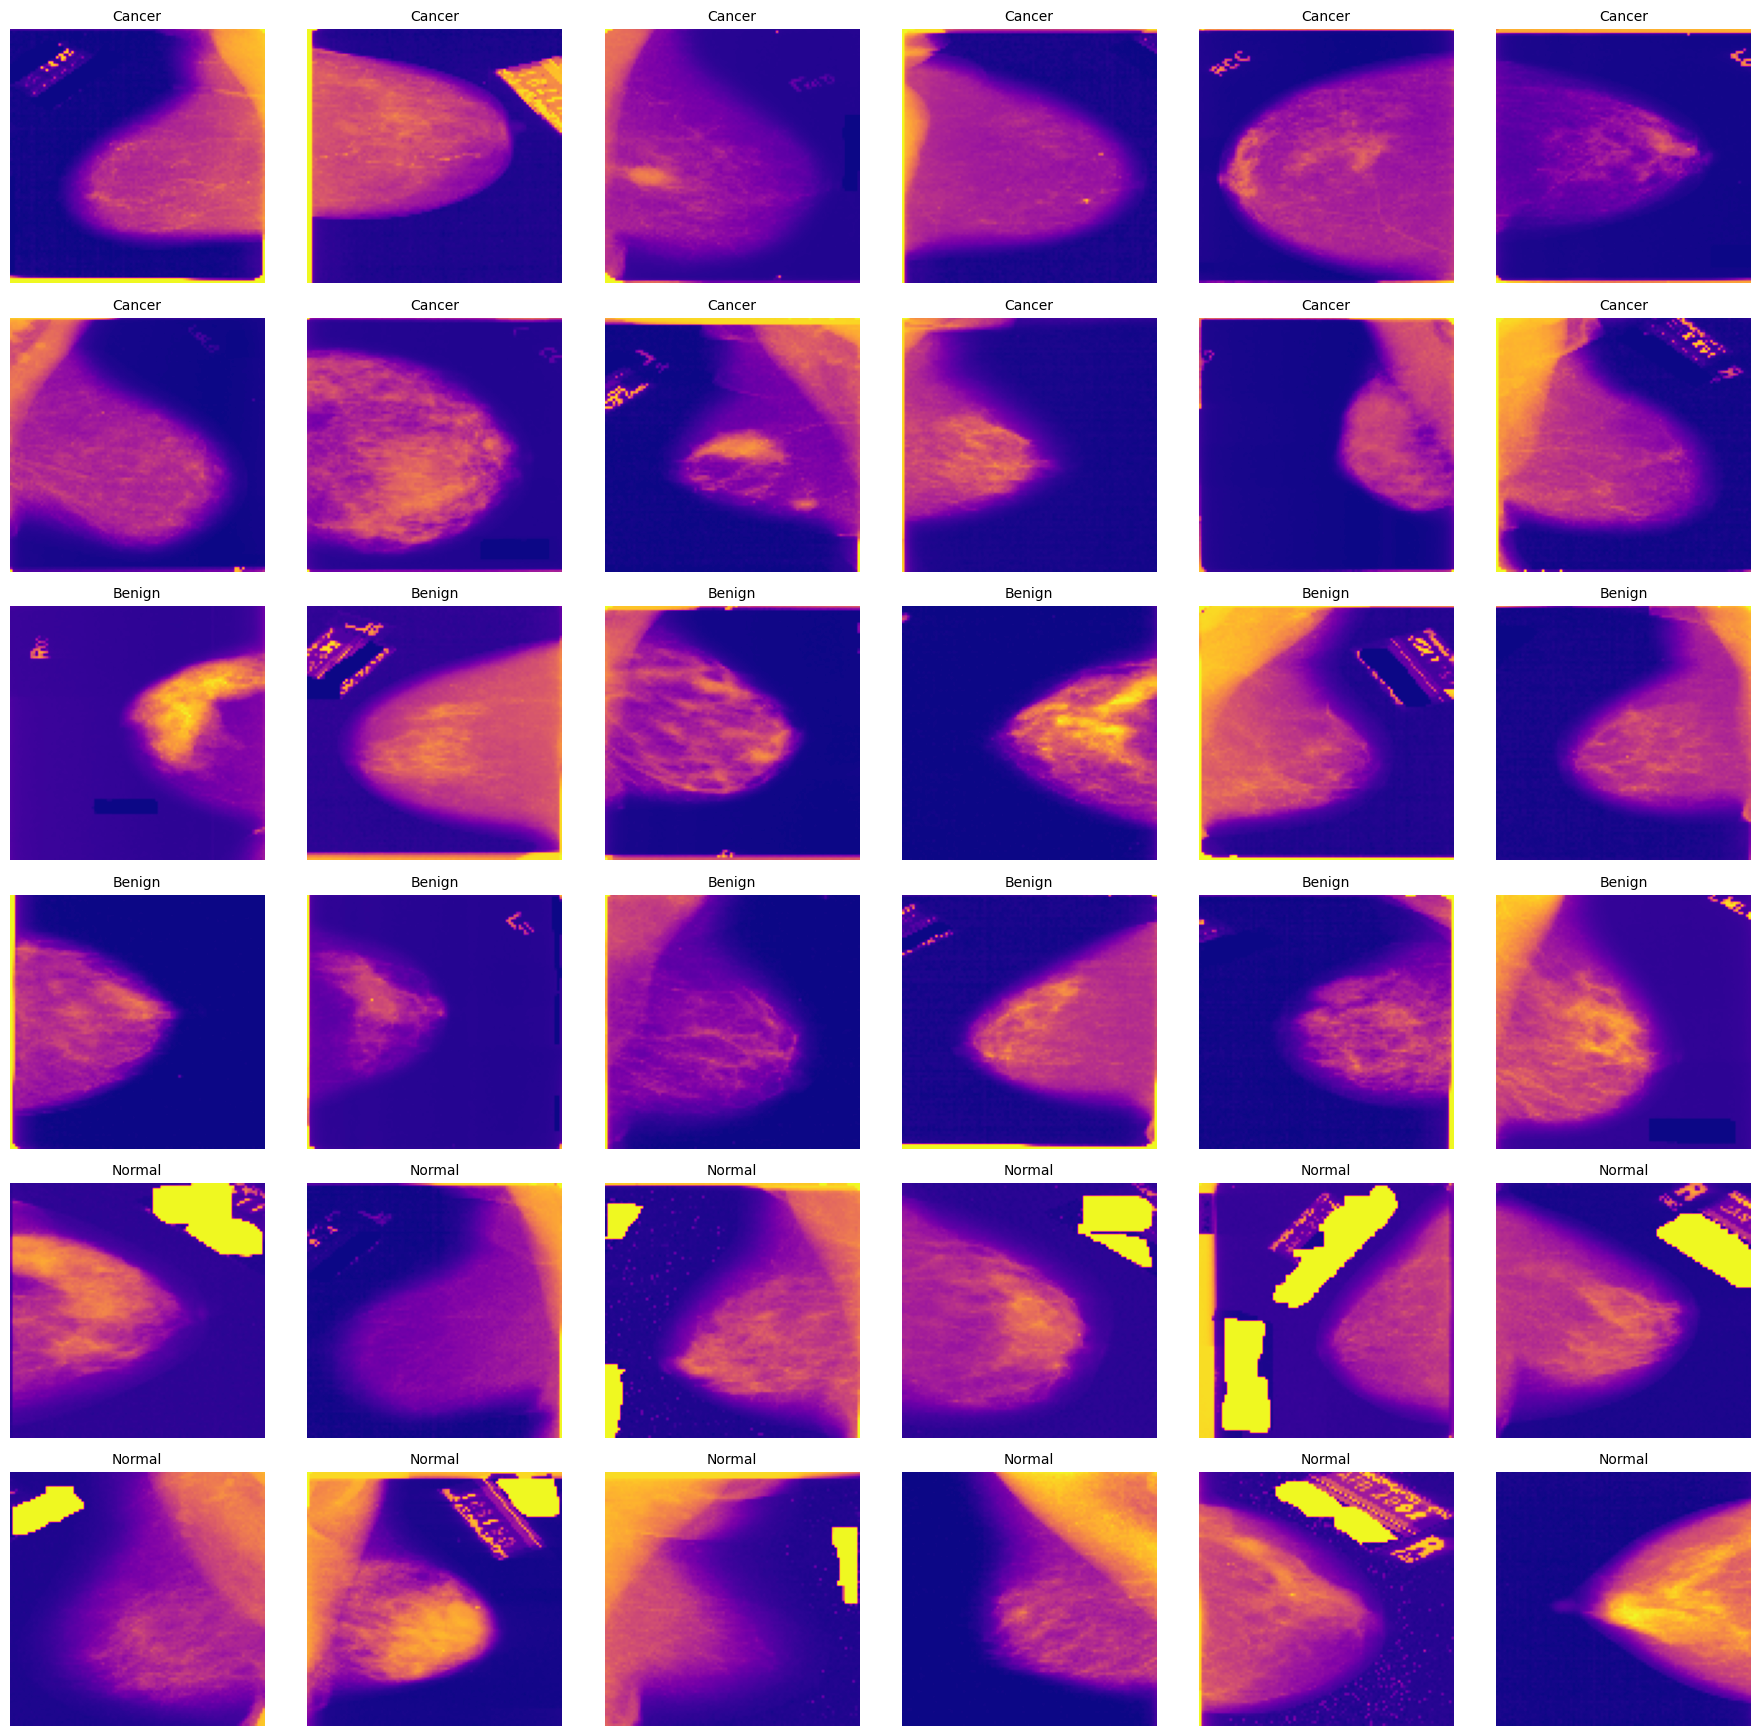

In [10]:
# Get images from 3 classes
cancer_imgs = glob.glob('Combined_MiniDDSM_imgs/Cancer/*.png')
benign_imgs = glob.glob('Combined_MiniDDSM_imgs/Benign/*.png')
normal_imgs = glob.glob('Combined_MiniDDSM_imgs/Normal/*.png')

# Sample 18 from each
some_can = np.random.choice(cancer_imgs, 18, replace=False)
some_ben = np.random.choice(benign_imgs, 18, replace=False)
some_nor = np.random.choice(normal_imgs, 18, replace=False)

# Create 6x6 grid showing the images
fig, axs = plt.subplots(6, 6, figsize=(18, 18))
classes = [('Cancer', some_can), ('Benign', some_ben), ('Normal', some_nor)]

for i, (label, images) in enumerate(classes):
    for j in range(18):
        row = (i * 2) + (j // 6 % 2)
        col = j % 6
        img = image.load_img(images[j], color_mode='grayscale', target_size=(100, 100))
        img_array = image.img_to_array(img).squeeze()

        axs[row, col].imshow(img_array, cmap='plasma')
        axs[row, col].axis('off')
        axs[row, col].set_title(label, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The grid above shows randomly selected samples of mammogram images from the Cancer, Benign, and Non-Cancer classes. These samples illustrate the visual intricacy and variability within classes, especially in cancerous cases.

### Preprocessing and Augmentation

Preprocessing and augmentation are being applied to improve generalization. Images are resized to 224×224 pixels with 32 images being processed per batch during training. Images are normalized to to [0.0, 1.0] and 20% of the data is reserved for validation and test. Augmentation was not done for validation and test set so that the model can be evaluated on unaltered images.

In [15]:
# 224×224 pixels input size
img_height, img_width = 224, 224
# Number of samples per batch
batch_size = 32

# preprocessing and augmentation for training set
train_data_generator = ImageDataGenerator(
    # Normalizing pixel values to [0, 1]
    rescale=1./255,
    # Randomly rotates images up to 15 degs
    rotation_range=15,
    # Randomly shifts images up to 10% of width horizontally
    width_shift_range=0.1,
    # Randomly shifts images up to 10% of height vertically
    height_shift_range=0.1,
    # Randomly zooms images up to 10%
    zoom_range=0.1,
    # False to retain left and right original views; no point flipping images horizontally or vertically
    horizontal_flip=False,
    vertical_flip=False,
    # This reserves 20% of data for validation
    validation_split=0.2
)

# preprocessing for validation and test set
# Normalizing pixel values to [0, 1]
test_data_generator = ImageDataGenerator(rescale=1./255)

### Train, Validation, Test Splitting

In [18]:
# training (80% of data)
training_set = train_data_generator.flow_from_directory(
    combined_img_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# validation (20% of data)
validation_set = train_data_generator.flow_from_directory(
    combined_img_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 6248 images belonging to 3 classes.
Found 1560 images belonging to 3 classes.


### Class Imbalance

After splitting training (80% of data) and validation (20% of data), class imbalance is addressed by adding class weights to prevent biasness. 

Training set class distribution count: {'Benign': 2148, 'Cancer': 2173, 'Normal': 1927}


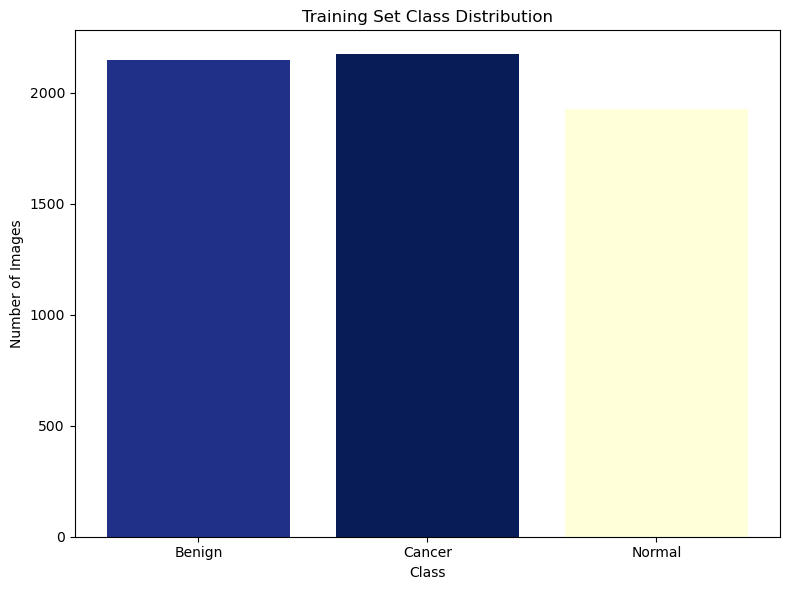

In [21]:
# class labels
labels = training_set.classes

# gets number of samples per class
unique, counts = np.unique(labels, return_counts=True)
print("Training set class distribution count:", dict(zip(training_set.class_indices, counts)))

# class names in order
class_names = list(training_set.class_indices.keys())

# color map and bar chart plotting
cmap = plt.get_cmap('YlGnBu')
norm = Normalize(vmin=min(counts), vmax=max(counts))
colors = [cmap(norm(count)) for count in counts]

plt.figure(figsize=(8, 6))
plt.bar(class_names, counts, color=colors)
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [23]:
class_weights = compute_class_weight(
    # Assigns weights inversely proportional to class frequencies
    class_weight='balanced',
    # Unique class labels
    classes=np.unique(labels),
    # The list of class labels
    y=labels
)

# Converts class weights to dictionary mapping class index to weight
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.9695841092489137, 1: 0.9584292069335788, 2: 1.0807818716485038}


## Developing a model that does better than a baseline

### Naive Baseline Model

The naive baseline model acts as a basic reference for assessing more complex architectures later in the project. It utilizes a simple CNN architecture and incorporates class weighting to tackle class imbalance. Although straightforward, this model sets a baseline expected performance and aids in uncovering initial issues, like misclassification trends or sensitivity to underrepresented classes. 

In [27]:
naive_baseline_model = models.Sequential([
    # Models input size
    layers.Input(shape=(img_height, img_width, 1)),

    # 32 filters with 3×3 kernel and ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu'),
    # MaxPooling2D(2, 2) downsamples the image by a factor of 2×2
    layers.MaxPooling2D(2, 2),

    # Filter is being increased to 64
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Filter is being increased to 128
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    # Fully connected layer with 128 neurons
    layers.Dense(128, activation='relu'),
    # Randomly drops 50% of the nodes to minimize overfitting
    layers.Dropout(0.5),

    # Final layer for the 3-classes using softmax activation
    layers.Dense(3, activation='softmax')
], name="naive_baseline_model")

naive_baseline_model.compile(
    optimizer='adam',
    # categorical_crossentrop for multi-class classification with one-hot encoded labels
    loss='categorical_crossentropy',
    metrics=['accuracy'])

naive_baseline_model.summary()

Model: "naive_baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,771 (42.61 MB)

 Trainable params: 11,168,771 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
naive_baseline_model_history = naive_baseline_model.fit(
    # Training data
    training_set,
    # Validation data
    validation_data=validation_set,
    # Number of Epochs
    epochs=20,
    # Class weights to address class imbalance
    class_weight=class_weights_dict
)

C:\Users\Shado\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1341s 7s/step - accuracy: 0.4217 - loss: 24.5553 - val_accuracy: 0.4673 - val_loss: 0.9866
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 870s 4s/step - accuracy: 0.5309 - loss: 0.9030 - val_accuracy: 0.4353 - val_loss: 1.1673
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 585s 3s/step - accuracy: 0.5655 - loss: 0.8321 - val_accuracy: 0.3942 - val_loss: 1.3795
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - accuracy: 0.5830 - loss: 0.8220 - val_accuracy: 0.4410 - val_loss: 1.0867
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.5875 - loss: 0.8202 - val_accuracy: 0.4083 - val_loss: 1.3986
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.6185 - loss: 0.7536 - val_accuracy: 0.4782 - val_loss: 1.1781
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - accuracy: 0.6146 - loss: 0.7419 - val_accuracy: 0.4500 - val_loss: 1.1405
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.6372 - loss: 0.6994 - val_ac

### Naive Baseline Model Evaluation

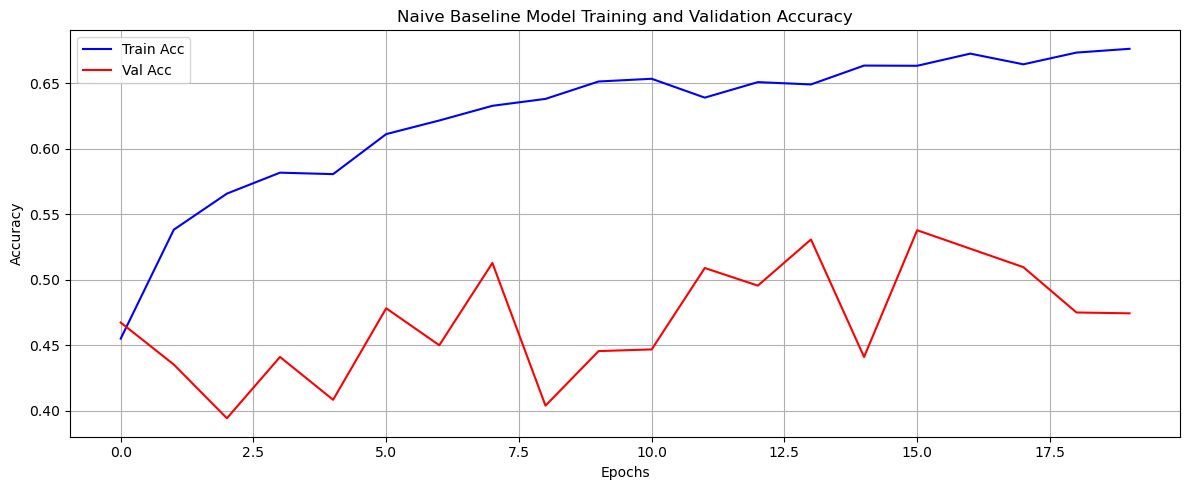

49/49 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step


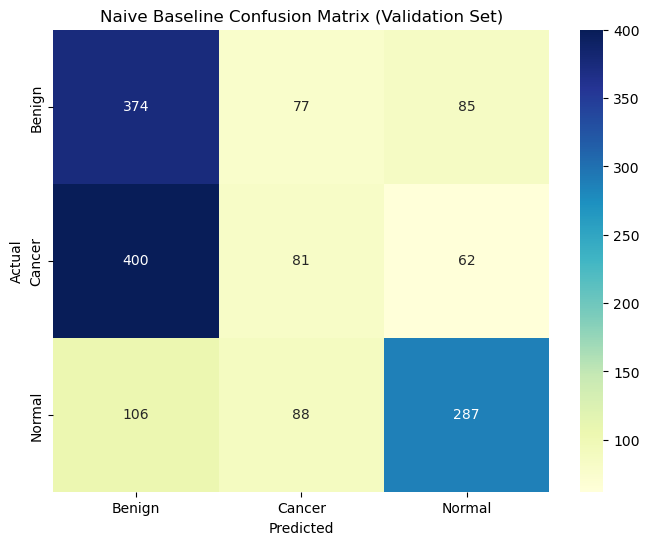

Naive Baseline Scores
              precision    recall  f1-score   support

      Benign       0.42      0.70      0.53       536
      Cancer       0.33      0.15      0.21       543
      Normal       0.66      0.60      0.63       481

    accuracy                           0.48      1560
   macro avg       0.47      0.48      0.45      1560
weighted avg       0.46      0.48      0.45      1560

Naive Baseline AUC-ROC (macro average): 0.6168780193044541


In [32]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.plot(naive_baseline_model_history.history['accuracy'], 'b-', label='Train Acc')
plt.plot(naive_baseline_model_history.history['val_accuracy'], 'r-', label='Val Acc')
plt.title("Naive Baseline Model Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# This predicts labels for validation set
naive_baseline_model_Y_pred = naive_baseline_model.predict(validation_set)
naive_baseline_model_y_pred = np.argmax(naive_baseline_model_Y_pred, axis=1)
naive_baseline_model_y_true = validation_set.classes
naive_baseline_model_class_labels = list(validation_set.class_indices.keys())

# Confusion Matrix
naive_baseline_model_confusion_matrix = confusion_matrix(naive_baseline_model_y_true, naive_baseline_model_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(naive_baseline_model_confusion_matrix, annot=True, fmt='d', xticklabels=naive_baseline_model_class_labels, yticklabels=naive_baseline_model_class_labels, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Baseline Confusion Matrix (Validation Set)')
plt.show()

# This prints classification Report for Precision, Sensitivity (Recall), F1-score
print("Naive Baseline Scores")
print(classification_report(naive_baseline_model_y_true, naive_baseline_model_y_pred, target_names=naive_baseline_model_class_labels,zero_division=0))

# Area Under the ROC Curve (AUC-ROC)
naive_baseline_model_y_true_binarized = label_binarize(naive_baseline_model_y_true, classes=[0, 1, 2])
naive_baseline_model_auc_roc = roc_auc_score(naive_baseline_model_y_true_binarized, naive_baseline_model_Y_pred, average='macro', multi_class='ovr')
print("Naive Baseline AUC-ROC (macro average):", naive_baseline_model_auc_roc)

As shown in the training and validation accuracy graphs, the model reached a maximum training accuracy of about 60%, whereas validation accuracy varied from 40% to 54%, indicating some overfitting and inconsistency in generalization. Even though adding class weights led to a more equitable classification result than an unweighted baseline, the performance on the validation set remains inadequate. The confusion matrix shows that the model was able to recognize all three classes to some extent.

Precision, Recall, and F1-Scores are non-zero precision for all classes, with the Cancer class having the highest recall (0.54) and the Normal class attaining the highest F1-score (0.52). The total Accuracy stands at 43%, with a macro-averaged F1-Score of 0.42, showing a notable enhancement in performance across classes. The AUC-ROC (macro average) score of 0.61 indicates improved ability to differentiate compared to random selection.

Even though the naïve baseline model uses class weighting to tackle class imbalance, its performance is still inconsistent across the classes, especially with significant misclassifications occurring between Benign and Cancer. To enhance generalization and minimize these errors, the next phase will include creating an improved baseline model with architectural advancements and regularization enhancements

### Baseline Model

The baseline model builds upon the naïve version by adding further improvements designed to enhance learning ability and generalization. Although still quite simple, the baseline model establishes a more solid and resilient benchmark, aiding in bridging the initial architecture with more intricate methods such as stratified cross-validation, transfer learning, or ensemble techniques. It has an essential function in assessing if additional enhancements are genuinely impactful.

In [35]:
baseline_model = models.Sequential([
    # Models input size
    layers.Input(shape=(img_height, img_width, 1)),

    # 32 filters with 3×3 kernel and ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    # MaxPooling2D(2, 2) downsamples the image by a factor of 2×2
    layers.MaxPooling2D(2, 2),

    # Filter is being increased to 64
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Filter is being increased to 128 and adds L2 weight decay to penalize overly large weights and reduce overfitting
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # This replaces Flatten, averaging the spatial dimensions and reducing the number of parameters
    layers.GlobalAveragePooling2D(),

    # Fully connected layer with 128 neurons
    layers.Dense(128, activation='relu'),
    # Randomly drops 50% of the nodes to minimize overfitting
    layers.Dropout(0.5),

    # Final layer for the 3-classes using softmax activation
    layers.Dense(3, activation='softmax')
], name="baseline_model")

baseline_model.compile(
    optimizer='adam',
    # categorical_crossentrop for multi-class classification with one-hot encoded labels
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,467 (431.51 KB)

 Trainable params: 110,019 (429.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
# Early stopping to stop training if no changes after consecutive epochs
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# checkpoint acts as a save file to restore best model weights from training
checkpoint = callbacks.ModelCheckpoint('baseline_model.keras', save_best_only=True)

baseline_model_history = baseline_model.fit(
    # Training data
    training_set,
    # Validation data
    validation_data=validation_set,
    # Number of Epochs
    epochs=30,
    # Class weights to address class imbalance
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - accuracy: 0.6595 - loss: 0.6643 - val_accuracy: 0.4840 - val_loss: 1.9804
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 763s 4s/step - accuracy: 0.6648 - loss: 0.6546 - val_accuracy: 0.3327 - val_loss: 3.8881
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.6810 - loss: 0.6329 - val_accuracy: 0.2301 - val_loss: 1.4522
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 773s 4s/step - accuracy: 0.6634 - loss: 0.6498 - val_accuracy: 0.2904 - val_loss: 1.8383
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 776s 4s/step - accuracy: 0.6710 - loss: 0.6518 - val_accuracy: 0.3038 - val_loss: 1.9676
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.6835 - loss: 0.6415 - val_accuracy: 0.4596 - val_loss: 1.2841
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - accuracy: 0.6773 - loss: 0.6504 - val_accuracy: 0.4494 - val_loss: 1.3892
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 676s 3s/step - accuracy: 0.6751 - loss: 0.6398 - val_accu

### Baseline Model Evaluation

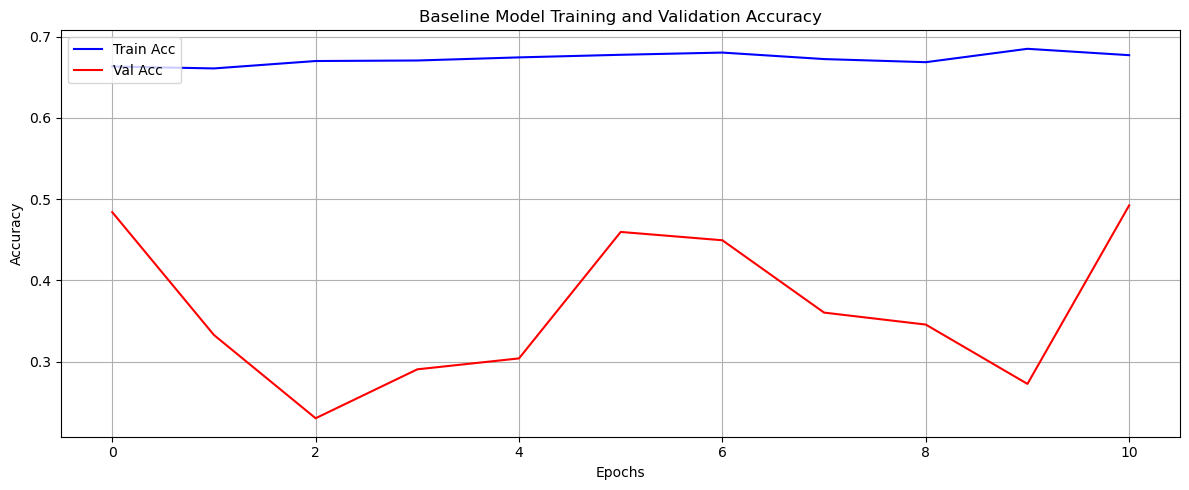

49/49 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step


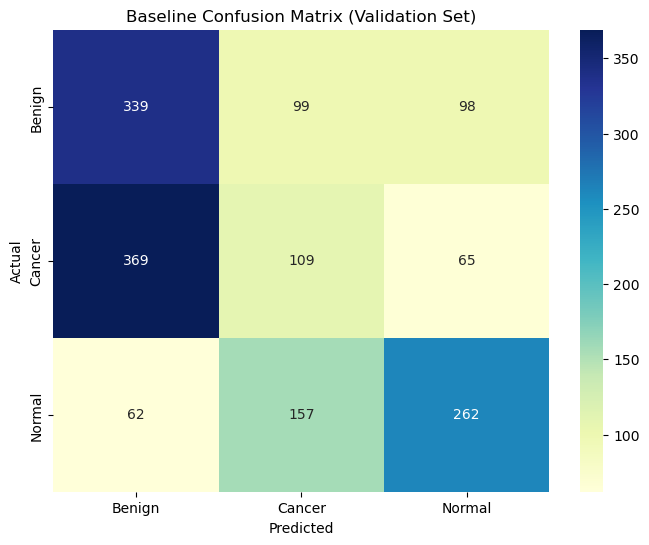

Baseline Model Scores
              precision    recall  f1-score   support

      Benign       0.44      0.63      0.52       536
      Cancer       0.30      0.20      0.24       543
      Normal       0.62      0.54      0.58       481

    accuracy                           0.46      1560
   macro avg       0.45      0.46      0.45      1560
weighted avg       0.45      0.46      0.44      1560

Baseline AUC-ROC (macro average): 0.5815512748174277


In [45]:
# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.plot(baseline_model_history.history['accuracy'], 'b-', label='Train Acc')
plt.plot(baseline_model_history.history['val_accuracy'], 'r-', label='Val Acc')
plt.title("Baseline Model Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Predict labels for validation set
baseline_Y_pred = baseline_model.predict(validation_set)
baseline_y_pred = np.argmax(baseline_Y_pred, axis=1)
baseline_y_true = validation_set.classes
baseline_class_labels = list(validation_set.class_indices.keys())

# Confusion Matrix
baseline_confusion_matrix = confusion_matrix(baseline_y_true, baseline_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(baseline_confusion_matrix, annot=True, fmt='d',
            xticklabels=baseline_class_labels, yticklabels=baseline_class_labels, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix (Validation Set)')
plt.show()

# Classification Report: Precision, Recall (Sensitivity), F1-score
print("Baseline Model Scores")
print(classification_report(baseline_y_true, baseline_y_pred,
                            target_names=baseline_class_labels, zero_division=0))

# AUC-ROC (Macro Average)
baseline_y_true_binarized = label_binarize(baseline_y_true, classes=[0, 1, 2])
baseline_auc_roc = roc_auc_score(baseline_y_true_binarized, baseline_Y_pred,
                                 average='macro', multi_class='ovr')
print("Baseline AUC-ROC (macro average):", baseline_auc_roc)
